Modality-specific preprocessing and dimensionality reduction.

To understand the distribution of gene expression in the current data, we load the single-cell RNA-seq dataset and compute basic gene-level statistics such as mean expression, variance, and dispersion (variance/mean).

               mean     variance    dispersion
count  2.000000e+03  2000.000000  2.000000e+03
mean  -6.537348e-03     0.745879  4.227490e+05
std    8.117796e-03     0.348090  7.536992e+05
min   -2.387043e-02     0.009794 -4.407208e+06
25%   -1.444693e-02     0.489850 -6.273597e+01
50%   -3.202007e-04     0.993303 -4.526398e+00
75%   -3.363201e-16     0.999967  9.999674e+05
max    2.811747e-14     0.999967  2.278476e+07


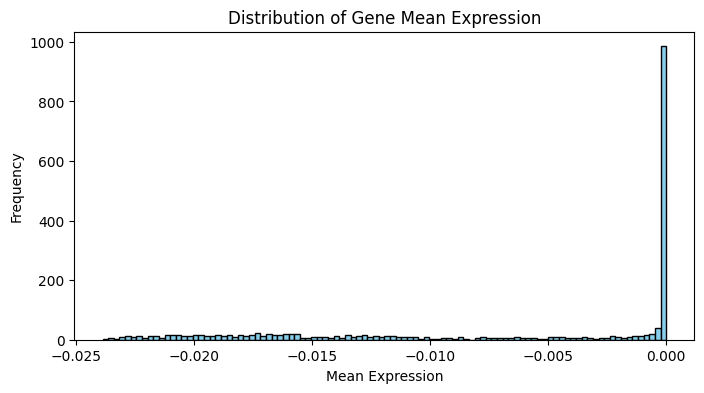

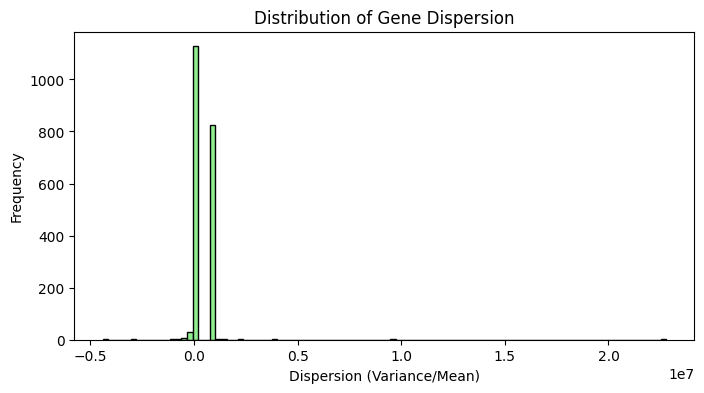

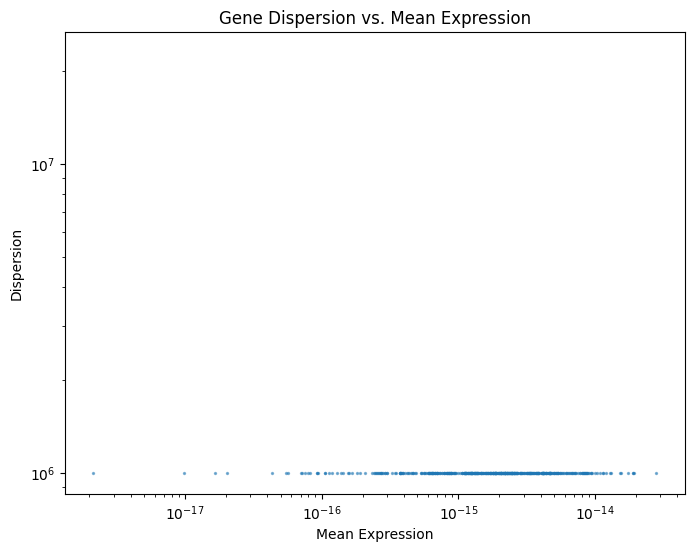

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse 

adata = sc.read_h5ad("data/processed/BM-CITE_RNA.h5ad") # change this to other datasets if needed

# If the data matrix is sparse and not too huge, convert to dense for computing statistics.
X = adata.X.toarray() if issparse(adata.X) else adata.X

# Compute gene-level summary statistics: mean, variance, and dispersion (variance/mean)
gene_means = X.mean(axis=0)
gene_vars = X.var(axis=0)
# Avoid division by zero by adding a small constant
gene_dispersion = gene_vars / (gene_means + 1e-6)

# Create a DataFrame for easy inspection
gene_stats = pd.DataFrame({
    'mean': gene_means,
    'variance': gene_vars,
    'dispersion': gene_dispersion
}, index=adata.var_names)

# Print summary statistics
print(gene_stats.describe())

# Plot the distribution of gene means
plt.figure(figsize=(8, 4))
plt.hist(gene_stats['mean'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Mean Expression')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Mean Expression')
plt.show()

# Plot the distribution of gene dispersions
plt.figure(figsize=(8, 4))
plt.hist(gene_stats['dispersion'], bins=100, color='lightgreen', edgecolor='black')
plt.xlabel('Dispersion (Variance/Mean)')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Dispersion')
plt.show()

# Scatter plot: dispersion vs. mean (log-log scale)
plt.figure(figsize=(8, 6))
plt.scatter(gene_stats['mean'], gene_stats['dispersion'], s=2, alpha=0.5)
plt.xlabel('Mean Expression')
plt.ylabel('Dispersion')
plt.title('Gene Dispersion vs. Mean Expression')
plt.xscale('log')
plt.yscale('log')
plt.show()

OK Let's move on to preprocess and reduce the RNA-seq data. The pipeline includes:

1. **Filtering cells and genes:** Remove cells with zero counts and genes expressed in fewer than 10 cells.
2. **Normalization:** Normalize total counts to 10,000 per cell and log-transform the data.
3. **Highly Variable Gene (HVG) selection:** Identify genes with high variability using the Seurat method.
4. **Scaling and PCA:** Scale the data and perform PCA for dimensionality reduction.

The output files will be stored in /reduced subfolder

In [18]:
import scanpy as sc
import numpy as np
import os

def preprocess_scRNA(h5ad_in, h5ad_out=None, n_top_genes=300):
    """
    Preprocessing pipeline for single-cell RNA-seq data.
    Handles edge cases like zero variances, NaNs, and ensures valid input for downstream steps.
    """
    adata = sc.read_h5ad(h5ad_in)
    
    # Convert to dense matrix if sparse
    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()
    
    # 1. Filter cells and genes
    sc.pp.filter_cells(adata, min_counts=1)  # Remove cells with zero counts
    sc.pp.filter_genes(adata, min_cells=10)  # Filter low-expressed genes
    
    # 2. Normalize and handle potential NaNs/negatives
    sc.pp.normalize_total(adata, target_sum=1e4)
    adata.X = np.clip(adata.X, 0, None)  # Ensure non-negative values
    adata.X = np.nan_to_num(adata.X)  # Replace any NaNs
    
    # 3. Log-transform safely
    sc.pp.log1p(adata)
    adata.X = np.nan_to_num(adata.X)  # Post-log cleanup
    
    # 4. Check if HVG selection is feasible
    try:
        # Compute gene means and variances
        mean = np.mean(adata.X, axis=0)
        variance = np.var(adata.X, axis=0)
        
        if np.all(variance == 0) or np.any(np.isnan(mean)) or np.any(np.isnan(variance)):
            raise ValueError("Insufficient variance or NaNs detected.")
        
        # Select HVGs with Seurat method
        sc.pp.highly_variable_genes(
            adata,
            flavor='seurat',
            n_top_genes=n_top_genes,
            min_mean=0.1,
            max_mean=3,
            min_disp=0.5
        )
        hvgs = adata.var[adata.var.highly_variable].index
    except Exception as e:
        print(f"HVG selection failed: {str(e)}. Using all genes.")
        hvgs = adata.var.index
    
    # 5. Subset to HVGs and proceed with scaling/PCA
    adata = adata[:, hvgs]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='randomized')
    
    if h5ad_out is not None:
        adata.write_h5ad(h5ad_out)
    
    return adata

# List all RNA files
rna_files = [f for f in os.listdir("data/processed") if f.endswith("_RNA.h5ad")]

# Process each RNA file
for rna_file in rna_files:
    input_file = os.path.join("data/processed", rna_file)
    output_file = os.path.join("data/processed/reduced", rna_file.replace(".h5ad", "_processed.h5ad"))
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    print(f"Processing {input_file}...")
    adata = preprocess_scRNA(input_file, output_file, n_top_genes=300)
    print(f"Saved processed data to {output_file}\n")

Processing data/processed\BM-CITE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\BM-CITE_RNA_processed.h5ad

Processing data/processed\LUNG-CITE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\LUNG-CITE_RNA_processed.h5ad

Processing data/processed\PBMC-DOGMA_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-DOGMA_RNA_processed.h5ad

Processing data/processed\PBMC-Multiome_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-Multiome_RNA_processed.h5ad

Processing data/processed\PBMC-TEA_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-TEA_RNA_processed.h5ad

Processing data/processed\Skin-SHARE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\Skin-SHARE_RNA_processed.h5ad



Sanity check: show PCA plots for each file.

<Figure size 800x600 with 0 Axes>

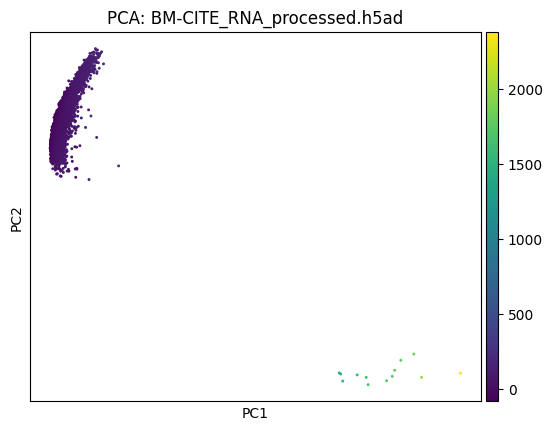

<Figure size 800x600 with 0 Axes>

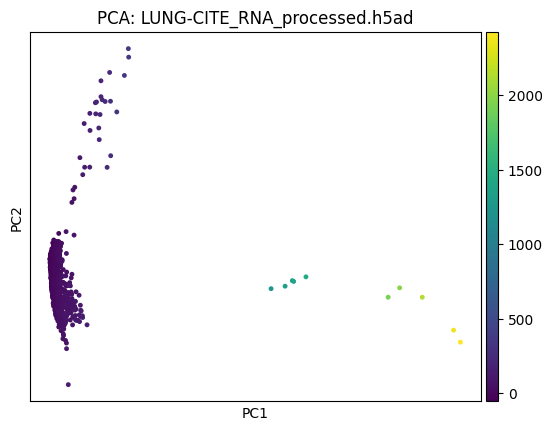

<Figure size 800x600 with 0 Axes>

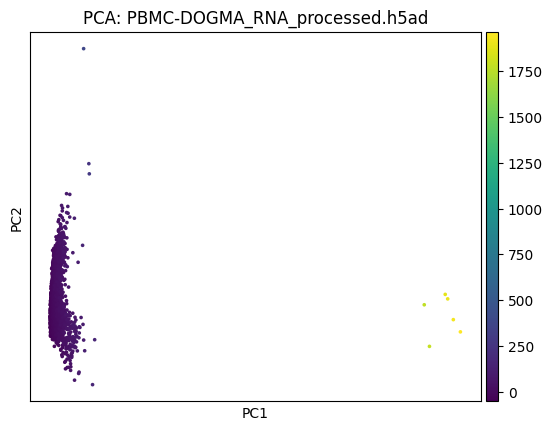

<Figure size 800x600 with 0 Axes>

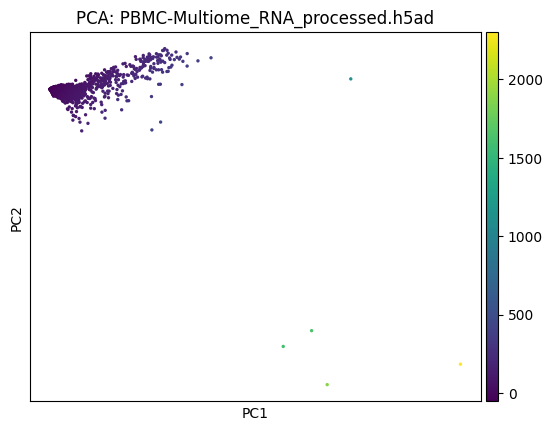

<Figure size 800x600 with 0 Axes>

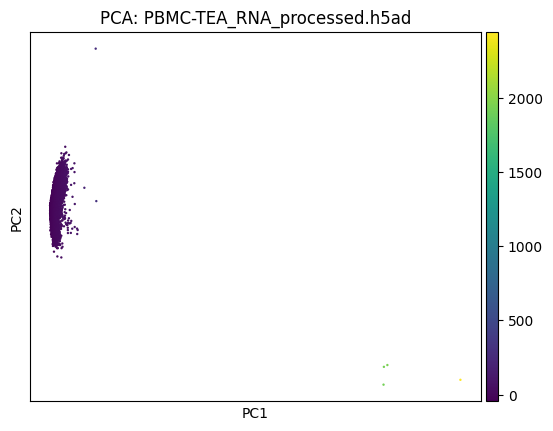

<Figure size 800x600 with 0 Axes>

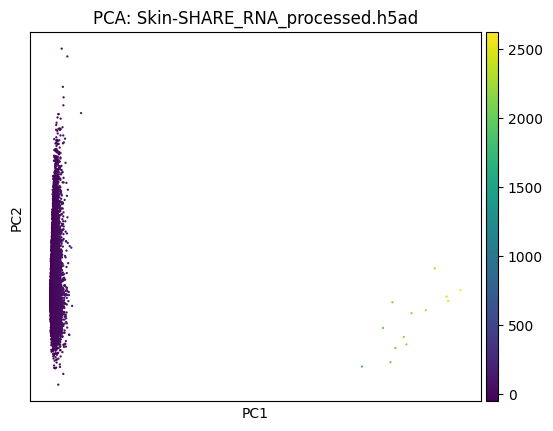

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing preprocessed files
processed_dir = "data/processed/reduced"

# List all preprocessed RNA files
rna_files = [f for f in os.listdir(processed_dir) if f.endswith("_RNA_processed.h5ad")]

# Plot PCA for each file
for rna_file in rna_files:
    # Load the preprocessed data
    adata = sc.read_h5ad(os.path.join(processed_dir, rna_file))
    
    # Compute total counts per cell
    if "total_counts" not in adata.obs:
        adata.obs["total_counts"] = np.sum(adata.X, axis=1)
    
    # Plot PCA components
    plt.figure(figsize=(8, 6))
    sc.pl.pca(adata, color="total_counts", title=f"PCA: {rna_file}")
    plt.show()